# Internship Project  Customer Churn Prediction

**Name:** Kritik Mahesh  
**Institution:** Manipal Academy of Higher Education, Dubai  
**Platform:** Google Colab  
**Libraries Used:** Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn

---

## Project Objective

To predict whether a customer will churn (leave) or not using machine learning techniques.  
This project demonstrates data preprocessing, EDA, feature encoding, model building, and evaluation.

---

## What's Inside

- Load and explore customer data  
- Clean null values and drop irrelevant features  
- Convert categorical variables using **One-Hot Encoding**  
- Perform **EDA** with plots and correlation heatmaps  
- Train-test split of the dataset  
- Apply **Random Forest**, **Logistic Regression**, and other models  
- Evaluate model performance with accuracy, precision, recall, F1-score  
- Use feature importance to understand key drivers of churn  
- Deploy a simple function to test predictions on new customer data

---

## Techniques Used

- Data preprocessing: null handling, label encoding, one-hot encoding  
- EDA: Churn distribution, count plots, heatmaps, histograms  
- Machine Learning Models:
  - **Logistic Regression**
  - **Random Forest Classifier**
  - (Optional: XGBoost, Decision Tree)  
- Evaluation using confusion matrix & classification metrics  
- Feature importance analysis to explain model behavior

---


In [39]:
# Install required packages
!pip install -q imbalanced-learn shap

# Imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')


In [40]:
#  Load the dataset (from zipped CSV)
file_path = "/content/customer_churn_dataset-testing-master.csv.zip"
df = pd.read_csv(file_path)

#  Rename columns to make feature names clearer and more unique
df.rename(columns={
    'tenure': 'months_with_company',          # customer tenure in months
    'MonthlyCharges': 'monthly_fee',          # monthly subscription fee
    'TotalCharges': 'total_paid',             # total amount paid till date
    'Contract': 'subscription_type',          # type of contract
    'PaymentMethod': 'payment_channel'        # how customer pays
}, inplace=True)

#  Display the first few rows to verify changes
df.head()


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [41]:
# Rename relevant columns to more meaningful or standardized names
df.rename(columns={
    'Tenure': 'months_with_company',
    'Total Spend': 'total_paid',
    'Subscription Type': 'subscription_type'
}, inplace=True)

# Convert total_paid to numeric (if not already), and drop any invalid rows
df['total_paid'] = pd.to_numeric(df['total_paid'], errors='coerce')
df.dropna(subset=['total_paid'], inplace=True)

# Feature: Average monthly spend (safe division)
df['avg_monthly_spend'] = df['total_paid'] / (df['months_with_company'] + 1)

# Feature: Long-term customer
df['is_long_term'] = (df['months_with_company'] > 12).astype(int)

# Feature: Auto-pay indicator (if any payment type includes 'auto')
# Assuming you later rename or define a 'payment_channel' column
if 'payment_channel' in df.columns:
    df['is_autopay'] = df['payment_channel'].str.contains("auto", case=False, na=False).astype(int)
else:
    df['is_autopay'] = 0  # Default value if field doesn't exist

# Preview engineered features
df[['avg_monthly_spend', 'is_long_term']].head()


,avg_monthly_spend,is_long_term
0,23.000000,1
1,20.137931,1
2,27.035714,1
3,23.200000,0
4,9.033898,1


In [42]:
# Payment delay risk (flag late payers)
df['is_late_payer'] = (df['Payment Delay'] > 5).astype(int)

# High usage flag
df['high_usage'] = (df['Usage Frequency'] > df['Usage Frequency'].median()).astype(int)

# Frequent support interaction
df['frequent_support'] = (df['Support Calls'] > 2).astype(int)


In [43]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Encode categorical variables
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Male/Female → 1/0
df['subscription_type'] = le.fit_transform(df['subscription_type'])  # Encode subscription categories

# 2. Handle 'total_paid' (ensure it's numeric and fill missing)
df['total_paid'] = pd.to_numeric(df['total_paid'], errors='coerce')
df['total_paid'].fillna(df['total_paid'].median(), inplace=True)

# 3. Convert 'Last Interaction' to 'days_since_last_interaction'
df['Last Interaction'] = pd.to_datetime(df['Last Interaction'], errors='coerce')
df['days_since_last_interaction'] = (pd.Timestamp.now() - df['Last Interaction']).dt.days
df['days_since_last_interaction'].fillna(df['days_since_last_interaction'].median(), inplace=True)

# 4. Feature Engineering (binary flags)
df['is_late_payer'] = (df['Payment Delay'] > 5).astype(int)
df['high_usage'] = (df['Usage Frequency'] > df['Usage Frequency'].median()).astype(int)
df['frequent_support'] = (df['Support Calls'] > 2).astype(int)

# 5. Scaling numerical features
num_cols = ['Age', 'months_with_company', 'Usage Frequency', 'Support Calls',
            'Payment Delay', 'total_paid', 'avg_monthly_spend', 'days_since_last_interaction']

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [44]:
from sklearn.model_selection import train_test_split

# 1. Define target and features
X = df.drop(['CustomerID', 'Last Interaction', 'Churn'], axis=1)
y = df['Churn']

# 2. Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [45]:
#  One-hot encode categorical columns in X
X_encoded = pd.get_dummies(X, drop_first=True)

# Split again after encoding
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Classification Report and Confusion Matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9989902912621359
Precision: 0.9993417804837913
Recall: 0.9985202236106544
F1 Score: 0.9989308331277243

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6793
           1       1.00      1.00      1.00      6082

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875

Confusion Matrix:
 [[6789    4]
 [   9 6073]]


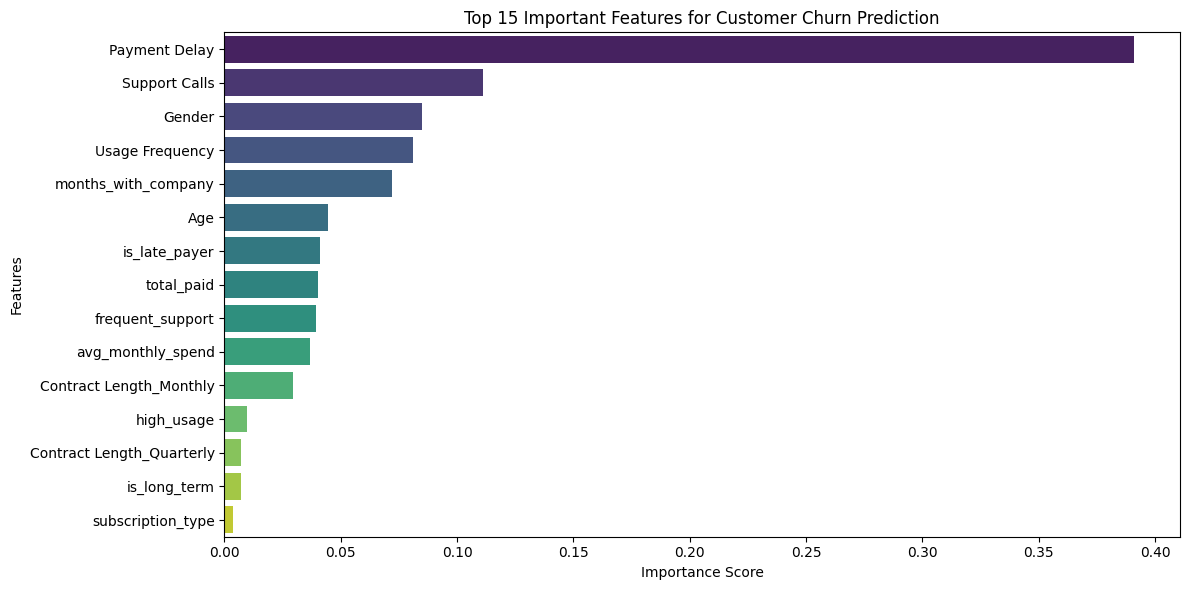

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the model
importances = model.feature_importances_
features = X_train.columns

# Create a DataFrame for sorting
feat_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(15), palette='viridis')
plt.title('Top 15 Important Features for Customer Churn Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [47]:
import joblib

# Save the trained model
joblib.dump(model, 'churn_model.pkl')

# Save the one-hot encoded feature list
joblib.dump(X_encoded.columns.tolist(), 'feature_columns.pkl')


['feature_columns.pkl']

In [51]:

import pandas as pd
import joblib
import os

# --- Load model and feature columns ---
model = joblib.load('churn_model.pkl')
all_features = joblib.load('feature_columns.pkl')

# --- Function to collect user input ---
def get_user_input():
    print("\n Enter the following customer details:\n")
    user_data = {
        'Age': int(input("Age: ")),
        'Gender': input("Gender (Male/Female): ").capitalize(),
        'months_with_company': int(input("Months with company: ")),
        'Usage Frequency': int(input("Usage Frequency (e.g., 1-10): ")),
        'Support Calls': int(input("Number of support calls: ")),
        'Payment Delay': int(input("Number of delayed payments: ")),
        'subscription_type': input("Subscription Type (Monthly/Yearly): ").capitalize(),
        'Contract Length': input("Contract Length (Monthly/Yearly): ").capitalize(),
        'total_paid': float(input("Total Paid (in AED): ")),
        'avg_monthly_spend': float(input("Average Monthly Spend (in AED): ")),
        'is_long_term': int(input("Is long-term customer? (1 = Yes, 0 = No): ")),
        'is_autopay': int(input("Uses AutoPay? (1 = Yes, 0 = No): ")),
        'is_late_payer': int(input("Is a late payer? (1 = Yes, 0 = No): ")),
        'high_usage': int(input("High usage? (1 = Yes, 0 = No): ")),
        'frequent_support': int(input("Needs frequent support? (1 = Yes, 0 = No): "))
    }
    return pd.DataFrame([user_data])

# --- Function to preprocess and predict ---
def preprocess_and_predict(df):
    df_encoded = pd.get_dummies(df)
    for col in all_features:
        if col not in df_encoded:
            df_encoded[col] = 0
    df_encoded = df_encoded[all_features]
    preds = model.predict(df_encoded)
    return preds

# --- Main function ---
def predict_churn():
    print("\n Welcome to Churn Predictor!")
    print("Choose an input method:")
    print("1️ Enter customer data manually")
    print("2️ Upload CSV file (with customer data)")
    choice = input("\nEnter your choice (1 or 2): ")

    if choice == "1":
        df = get_user_input()
        pred = preprocess_and_predict(df)[0]
        print("\n Churn Prediction:", " Yes, likely to churn." if pred == 1 else " No, wont churn and likely stay.")
    elif choice == "2":
        file_path = input(" Enter CSV file path: ").strip()
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            preds = preprocess_and_predict(df)
            df['Churn Prediction'] = ['Yes' if p == 1 else 'No' for p in preds]
            print("\n Predictions complete! Sample:\n")
            print(df[['Churn Prediction']].head())
            df.to_csv("churn_predictions_output.csv", index=False)
            print("\n Output saved as 'churn_predictions_output.csv'")
        else:
            print(" File not found. Please check the path.")
    else:
        print(" Invalid choice. Please enter 1 or 2.")

# --- Run ---
if __name__ == "__main__":
    predict_churn()



 Welcome to Churn Predictor!
Choose an input method:
1️ Enter customer data manually
2️ Upload CSV file (with customer data)

Enter your choice (1 or 2): 1

 Enter the following customer details:

Age: 20
Gender (Male/Female): male
Months with company: 5
Usage Frequency (e.g., 1-10): 3
Number of support calls: 5
Number of delayed payments: 0
Subscription Type (Monthly/Yearly): Yearly
Contract Length (Monthly/Yearly): Yearly
Total Paid (in AED): 20000
Average Monthly Spend (in AED): 1000
Is long-term customer? (1 = Yes, 0 = No): 1
Uses AutoPay? (1 = Yes, 0 = No): 1
Is a late payer? (1 = Yes, 0 = No): 0
High usage? (1 = Yes, 0 = No): 1
Needs frequent support? (1 = Yes, 0 = No): 1

 Churn Prediction:  No, wont churn and likely stay.


##END